In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings

path = 'housing.csv'
housing = pd.DataFrame(pd.read_csv(path))
housing.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [203]:
# List of variables to map

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0, 'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


In [204]:
np.random.seed(10)
df_train, df_validate = train_test_split(housing, train_size=0.8, test_size=0.2, random_state=100)

y_train = df_train.pop('price')
X_train = df_train

y_validate = df_validate.pop('price')
X_validate = df_validate
X_train.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
22,8050,3,1,1,1,1,1,0,1,1,0,2
41,6360,3,2,4,1,0,0,0,1,0,1,2
91,6750,2,1,1,1,1,1,0,0,2,1,2
118,6420,3,1,1,1,0,1,0,1,0,1,2
472,3630,4,1,2,1,0,0,0,0,3,0,1


In [205]:
a_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
X_train_df_a = X_train[a_vars]
X_validate_df_a = X_validate[a_vars]
X_train_df_a.head()

,area,bedrooms,bathrooms,stories,parking
22,8050,3,1,1,1
41,6360,3,2,4,0
91,6750,2,1,1,2
118,6420,3,1,1,0
472,3630,4,1,2,3


In [206]:
def gen_data(df: pd.DataFrame):
    if isinstance(df, pd.DataFrame):
        data = df.to_numpy()
    data = df
    X0 = np.ones((data.shape[0], 1))
    X = np.hstack((X0, data))
    return X
X_train_a = gen_data(X_train_df_a)
X_validate_a = gen_data(X_validate_df_a)

Y_train = y_train.to_numpy().reshape(-1,1)
Y_validate = y_validate.to_numpy().reshape(-1,1)

In [207]:
# vars: Area, bedrooms, bathrooms, stories, mainroad, guestroom, basement, hotwaterheating, airconditioning, parking, prefarea
b_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']
X_train_df_b = X_train[b_vars]
X_validate_df_b = X_validate[b_vars]

X_train_b = gen_data(X_train_df_b)
X_validate_b = gen_data(X_validate_df_b)

In [208]:
def compute_cost(X, Y, theta):
    m = X.shape[0]
    predictions = X.dot(theta)
    errors = np.subtract(predictions, Y)
    sqrErrors = np.square(errors)
    J = (1/ (2*m) ) * np.sum(sqrErrors)
    
    return J
def compute_regularized_cost(X, Y, theta, lambda_val):
    m = X.shape[0]
    predictions = X.dot(theta)
    errors = np.subtract(predictions, Y)
    sqrErrors = np.square(errors)
    J = (1/ (2*m) ) * np.sum(sqrErrors) * lambda_val * np.sum(np.square(theta))
    
    return J
    
    

def grad_desc(X_train: np.ndarray, Y_train: np.ndarray, theta: np.ndarray, alpha: float, iterations: int, X_val: np.ndarray, Y_val: np.ndarray, lambda_val=0):
    m = len(Y_train)
    
    training_cost_history = np.zeros(iterations)
    validation_cost_history = np.zeros(iterations)
    
    for i in range(iterations):
        validation_cost_history[i] = compute_cost(X_val, Y_val, theta)
        
        predictions = X_train.dot(theta)
        errors = np.subtract(predictions, Y_train)
        
        sum_deltas = (alpha/m) * X_train.T.dot(errors) + lambda_val * theta
        
        theta -= sum_deltas
        
        sqrErrors = np.square(errors)
        training_cost_history[i]= (1/ (2*m) ) * np.sum(sqrErrors)
        
    
    return theta,training_cost_history, validation_cost_history


In [209]:
def print_model(X, Y, theta, name='Y'):
    
    cost = compute_cost(X,Y,theta)
    
    model_str = ""
    
    for i in range(theta.shape[0]-1, -1, -1):
        if i == 0:
            model_str += f"{round(theta[i,0], 3)}"
            break
        model_str += f"{round(theta[i,0], 3)}*X{i} + "
    
    print(f"Model:\n    {name} = {model_str}") 
    cost_str = "{:e}".format(round(cost,3))
    print(f"    cost = {cost_str}")

def display_loss(iters, train_hist, val_hist, title):
    plt.plot(range(iters), train_hist, label = "Training")
    plt.plot(range(iters), val_hist, label = "Validation")
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()
    
    plt.show()
    

In [210]:
#Used to find max iters before overflow error
def find_iters(X_train_b, Y_train, theta, alpha, X_validate_b, Y_validate):
    alpha = 0.01
    for iterations in range(1,50):
        theta = np.zeros((X_train_b.shape[1], 1))
        with warnings.catch_warnings(record=True) as w:
            
            warnings.filterwarnings(   
                action = 'default',
                module=__name__
            )
            
            theta, training_cost_history, validation_cost_history = grad_desc(X_train_b, Y_train, theta, alpha, iterations, X_validate_b, Y_validate)
            
            if w:
                print(w[-1].message)
                print(f"error at {iterations} iters")
                break
    return iterations
            


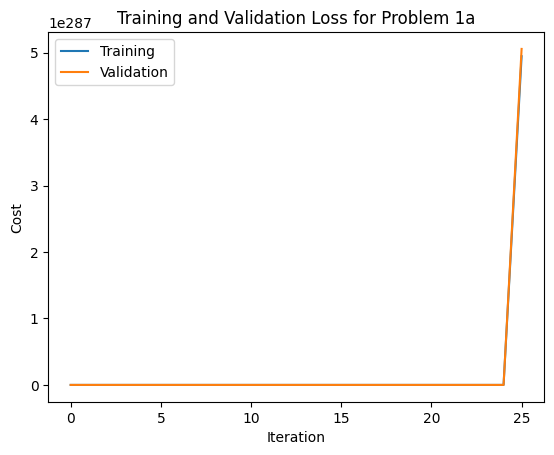

Model:
    Y = -7.83233710742242e+141*X5 + -1.6909630947856312e+142*X4 + -1.221092510935228e+142*X3 + -2.7363575423672495e+142*X2 + -5.545212555934865e+145*X1 + -9.176913795971532e+141
    cost = 4.886221e+298


In [211]:
# Problem 1a

theta = np.zeros((X_train_a.shape[1], 1))

# 26 iters was found to be the maximum number of iterations before overflow occured
iterations = 26
# Alpha of 0.01 minimizes cost
alpha = 0.01

theta, training_cost_history, validation_cost_history = grad_desc(X_train_a, Y_train, theta, alpha, iterations, X_validate_a, Y_validate)

display_loss(iterations, training_cost_history, validation_cost_history, "Training and Validation Loss for Problem 1a")
print_model(X_validate_a, Y_validate, theta)

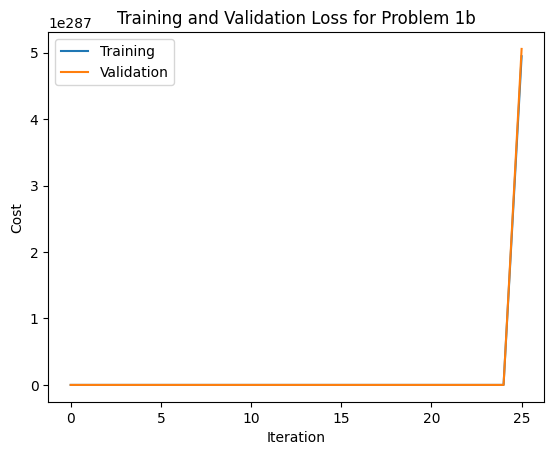

Model:
    Y = -2.4782014281861457e+141*X11 + -7.83234351533642e+141*X10 + -3.119120726333628e+141*X9 + -5.0942354417649356e+140*X8 + -3.384198320454165e+141*X7 + -1.805419802309611e+141*X6 + -8.319341935468041e+141*X5 + -1.6909644821763613e+142*X4 + -1.2210935119529034e+142*X3 + -2.736359786078765e+142*X2 + -5.54521708509379e+145*X1 + -9.176921321492281e+141
    cost = 4.886230e+298


In [212]:
# Problem 1b

warnings.simplefilter("ignore")

theta = np.zeros((X_train_b.shape[1], 1))

# 26 iters was found to be the maximum number of iterations before overflow occured
iterations = 26
# Alpha of 0.01 minimizes cost
alpha = 0.01

theta, training_cost_history, validation_cost_history = grad_desc(X_train_b, Y_train, theta, alpha, iterations, X_validate_b, Y_validate)

display_loss(iterations, training_cost_history, validation_cost_history, "Training and Validation Loss for Problem 1b")
print_model(X_validate_b, Y_validate, theta)

In [213]:
norm = MinMaxScaler()
std = StandardScaler()

X_train_a_norm = gen_data(norm.fit_transform(X_train_df_a))
X_train_a_std = gen_data(std.fit_transform(X_train_df_a))
X_validate_a_norm = gen_data(norm.fit_transform(X_validate_df_a))
X_validate_a_std = gen_data(std.fit_transform(X_validate_df_a))

X_train_b_norm = gen_data(norm.fit_transform(X_train_df_b))
X_train_b_std = gen_data(std.fit_transform(X_train_df_b))
X_validate_b_norm = gen_data(norm.fit_transform(X_validate_df_b))
X_validate_b_std = gen_data(std.fit_transform(X_validate_df_b))

X_train_full_norm = gen_data(norm.fit_transform(X_train))
X_train_full_std = gen_data(std.fit_transform(X_train))
X_validate_full_norm = gen_data(norm.fit_transform(X_validate))
X_validate_full_std = gen_data(std.fit_transform(X_validate))


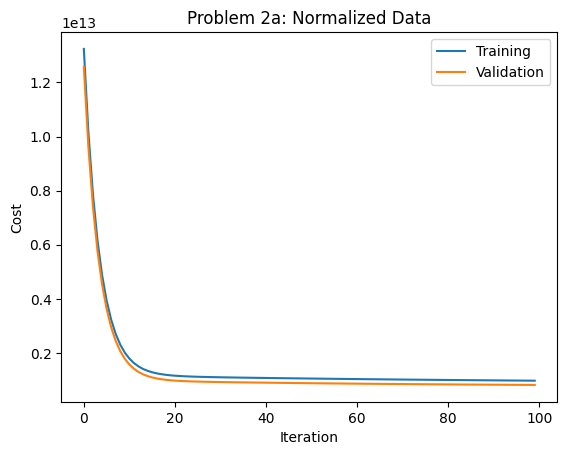

Model:
    Y = 1350985.476*X5 + 1546192.908*X4 + 1277373.516*X3 + 1440171.77*X2 + 1632704.757*X1 + 3021821.857
    cost = 8.181003e+11


In [214]:
#find_iters(X_train_a_norm, Y_train, theta, 0.01, X_validate_a_norm, Y_validate)


theta = np.zeros((X_train_a_norm.shape[1], 1))

# 26 iters was found to be the maximum number of iterations before overflow occured
iterations = 100
# Alpha of 0.01 minimizes cost
alpha = .1

theta, training_cost_history, validation_cost_history = grad_desc(X_train_a_norm, Y_train, theta, alpha, iterations, X_validate_a_norm, Y_validate)

display_loss(iterations, training_cost_history, validation_cost_history, "Problem 2a: Normalized Data")
print_model(X_validate_a_norm, Y_validate, theta)


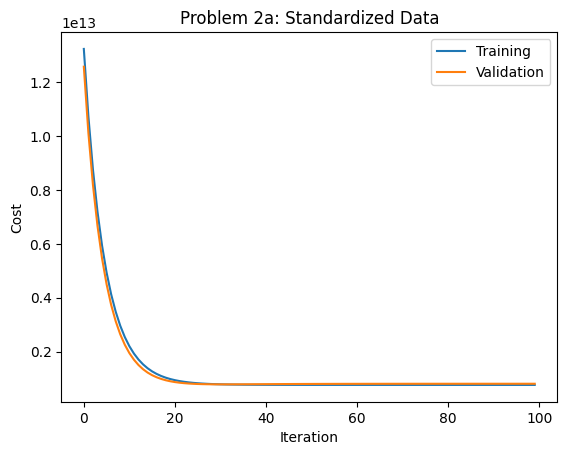

Model:
    Y = 287379.594*X5 + 463339.493*X4 + 640949.774*X3 + 80151.506*X2 + 729803.612*X1 + 4795601.839
    cost = 8.047521e+11


In [215]:
theta = np.zeros((X_train_a_std.shape[1], 1))

# 26 iters was found to be the maximum number of iterations before overflow occured
iterations = 100
# Alpha of 0.01 minimizes cost
alpha = .1

theta, training_cost_history, validation_cost_history = grad_desc(X_train_a_std, Y_train, theta, alpha, iterations, X_validate_a_std, Y_validate)

display_loss(iterations, training_cost_history, validation_cost_history, "Problem 2a: Standardized Data")
print_model(X_validate_a_std, Y_validate, theta)

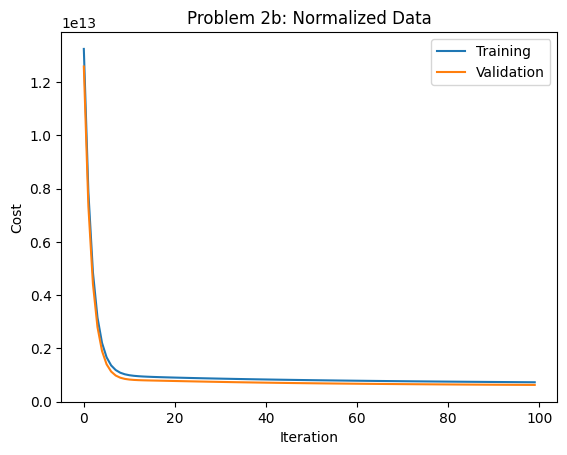

Model:
    Y = 631592.054*X11 + 925928.939*X10 + 1099283.58*X9 + 497071.592*X8 + 368473.073*X7 + 516373.048*X6 + 1157613.42*X5 + 1180737.55*X4 + 1093854.665*X3 + 1010324.236*X2 + 1041285.411*X1 + 1793837.767
    cost = 6.288257e+11


In [216]:
# Problem 2b
# Train on X_train_b_norm

theta = np.zeros((X_train_b_norm.shape[1], 1))

iterations = 100
alpha = 0.1

theta, training_cost_history, validation_cost_history = grad_desc(X_train_b_norm, Y_train, theta, alpha, iterations, X_validate_b_norm, Y_validate)
display_loss(iterations, training_cost_history, validation_cost_history, "Problem 2b: Normalized Data")
print_model(X_validate_b_norm, Y_validate, theta)

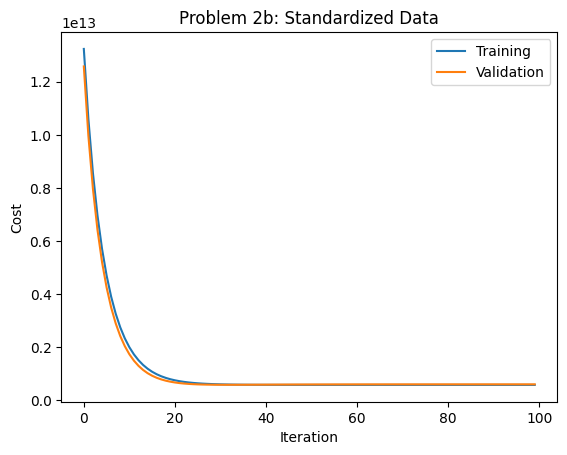

Model:
    Y = 256016.177*X11 + 222410.592*X10 + 400417.832*X9 + 205067.948*X8 + 144333.27*X7 + 146670.67*X6 + 210752.897*X5 + 366223.09*X4 + 578316.173*X3 + 73967.452*X2 + 532248.086*X1 + 4795601.839
    cost = 5.965256e+11


In [217]:
# Problem 2b 
# train on X_train_b_std

theta = np.zeros((X_train_b_std.shape[1], 1))

iterations = 100
alpha = 0.1

theta, training_cost_history, validation_cost_history = grad_desc(X_train_b_std, Y_train, theta, alpha, iterations, X_validate_b_std, Y_validate)

display_loss(iterations, training_cost_history, validation_cost_history, "Problem 2b: Standardized Data")
print_model(X_validate_b_std, Y_validate, theta)


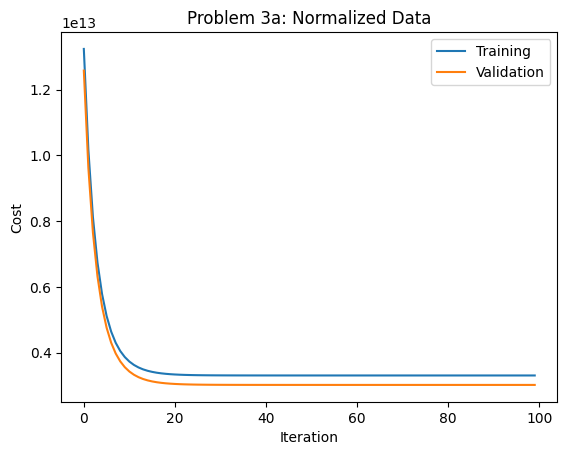

Model:
    Y = 604293.553*X5 + 684682.229*X4 + 326034.25*X3 + 829077.524*X2 + 578058.856*X1 + 1987260.021
    cost = 3.019059e+12


In [218]:
# Problem 3a
# Train on X_train_a_norm

theta = np.zeros((X_train_a_norm.shape[1], 1))

# lambda 0 cost = 8.181003e+11

iterations = 100
alpha = 0.1

lambda_val = .1

theta, training_cost_history, validation_cost_history = grad_desc(X_train_a_norm, Y_train, theta, alpha, iterations, X_validate_a_norm, Y_validate, lambda_val = lambda_val)

display_loss(iterations, training_cost_history, validation_cost_history, "Problem 3a: Normalized Data")
print_model(X_validate_a_norm, Y_validate, theta)



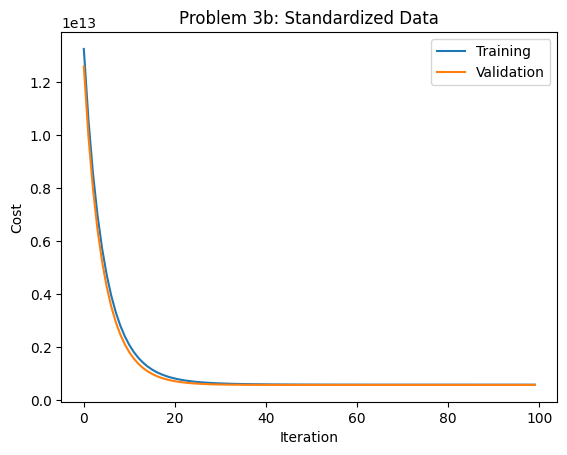

Model:
    Y = 251253.336*X11 + 222435.885*X10 + 392068.182*X9 + 196909.914*X8 + 139679.014*X7 + 148559.793*X6 + 209846.207*X5 + 356238.152*X4 + 560306.076*X3 + 85472.681*X2 + 517321.43*X1 + 4611199.641
    cost = 5.827937e+11


In [219]:
# Problem 3b
# Train on X_train_b_std

theta = np.zeros((X_train_b_std.shape[1], 1))

iterations = 100
alpha = 0.1
lambda_val = 0.004

theta, training_cost_history, validation_cost_history = grad_desc(X_train_b_std, Y_train, theta, alpha, iterations, X_validate_b_std, Y_validate, lambda_val=lambda_val)
# print(np.min(lambdas, axis=0))
display_loss(iterations, training_cost_history, validation_cost_history, "Problem 3b: Standardized Data")
print_model(X_validate_b_std, Y_validate, theta)

# Could not improve loss with normalization


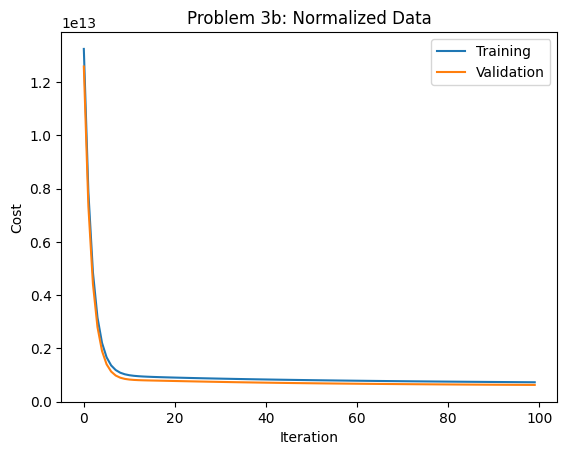

Model:
    Y = 631591.925*X11 + 925928.561*X10 + 1099283.291*X9 + 497071.225*X8 + 368473.283*X7 + 516372.913*X6 + 1157613.79*X5 + 1180737.032*X4 + 1093853.844*X3 + 1010323.97*X2 + 1041284.838*X1 + 1793837.712
    cost = 6.288258e+11


In [220]:
# Problem 3b: Normalized Data

# Problem 2b
# Train on X_train_b_std

theta = np.zeros((X_train_b_norm.shape[1], 1))

iterations = 100
alpha = 0.1
lambda_val = .00000002
# 288257e11

theta, training_cost_history, validation_cost_history = grad_desc(X_train_b_norm, Y_train, theta, alpha, iterations, X_validate_b_norm, Y_validate, lambda_val=lambda_val)
display_loss(iterations, training_cost_history, validation_cost_history, "Problem 3b: Normalized Data")
print_model(X_validate_b_norm, Y_validate, theta)

# lambdas = np.ones((int(1/lambda_val)-1, 2)) * 1e100
# i = 0
# while lambda_val < 1:
#     theta, training_cost_history, validation_cost_history = grad_desc(X_train_b_norm, Y_train, theta, alpha, iterations, X_validate_b_norm, Y_validate, lambda_val=0.01)
#     lambdas[i] = [lambda_val, validation_cost_history[-1]]
#     lambda_val += 0.001
#     i+= 1

# print(np.min(lambdas, axis=0))
